# Urban 8k Audio Classification Project

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

#Libraries for Classification Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

## Data Processing

In [2]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2021-11-21 09:42:56--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  19.4MB/s    in 4m 50s  

2021-11-21 09:47:47 (19.8 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



## Data Analysis

We will perform a set of data analysis steps to observe and see patterns in the data given and choose the best modeling accordingly. 

### Data Statistics
We want to see how the audio files were recorded and how the different classes are distributed.

In [3]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [4]:
df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav


In [5]:
print("Count in each class of urban sound 8k dataset=\n")
print(df['class'].value_counts())
print("\nNumber of training sets and val sets= ",df.shape[0],"\nNumber of classes= ",len(df['class'].unique()))

Count in each class of urban sound 8k dataset=

dog_bark            1000
children_playing    1000
engine_idling       1000
jackhammer          1000
street_music        1000
drilling            1000
air_conditioner     1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

Number of training sets and val sets=  8732 
Number of classes=  10


In [6]:
#Feature Extraction and mel_spectogram function of librosa to extract the spectogram data as a numpy array
feature = []
label = []

def parser():
    # Function to load files and extract features
    for i in tqdm(range(1,8732)):
        file_name = 'UrbanSound8K/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data , first extracting 3s per file....ie 22050*0.5=11025
        #applying segmentation:
        segment_1s=[X[ k*22050 : k*22050+22050 ] for k in range(int(len(X)/22050))]
        for audio_1s in segment_1s:
            mels = librosa.feature.melspectrogram(y=audio_1s, sr=sample_rate).T  
            feature.append(mels)
            label.append(df["classID"][i])
    return [feature,label]

In [ ]:
print(label[0])

print(feature[0])

In [7]:
temp = parser()

100%|██████████| 8731/8731 [14:40<00:00,  9.91it/s]


In [8]:
%%time

temp = np.array(temp, dtype=object)
data = temp.transpose()

CPU times: user 4.6 ms, sys: 4.49 ms, total: 9.08 ms
Wall time: 4.61 ms


In [9]:
data.shape

(30825, 2)

In [10]:
X_ = data[:, 0]
Y = data[:, 1]
#print(X_.shape, Y.shape)
X = np.empty([X_.shape[0],44,128])

print(X_.shape)
print(X_[0].shape)
print(X.shape)

(30825,)
(44, 128)
(30825, 44, 128)


In [11]:
for i in range(len(X_)):
    X[i] = X_[i]

In [12]:
X_[0].shape

(44, 128)

In [13]:
Y = to_categorical(Y, num_classes=10)

In [14]:
# Final Data
print(X.shape)
print(Y.shape)

(30825, 44, 128)
(30825, 10)


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [16]:
len(X_test)

7707

In [17]:
print(len(X_train))
print(len(Y_train))

23118
23118


In [18]:
X_train = X_train.reshape(-1, 128, 44, 1)
X_test = X_test.reshape(-1, 128, 44, 1)

In [19]:
len(Y_test)

7707

In [20]:
input_dim = (128, 44, 1)

In [21]:
#CREATING A KERAS MODEL AND TESTING

model = Sequential()
model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

In [22]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 44, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 22, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 11, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 11, 128)       0         
                                                                 
 flatten (Flatten)           (None, 45056)             0

In [24]:
%%time

hist = model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
463/463 [==============================] - 62s 69ms/step - loss: 2.6790 - accuracy: 0.3456 - val_loss: 1.6188 - val_accuracy: 0.4418
Epoch 2/90
463/463 [==============================] - 33s 71ms/step - loss: 1.4122 - accuracy: 0.5177 - val_loss: 1.3421 - val_accuracy: 0.5542
Epoch 3/90
463/463 [==============================] - 31s 67ms/step - loss: 1.1322 - accuracy: 0.6166 - val_loss: 1.1399 - val_accuracy: 0.6364
Epoch 4/90
463/463 [==============================] - 31s 67ms/step - loss: 0.9173 - accuracy: 0.6956 - val_loss: 1.0287 - val_accuracy: 0.6844
Epoch 5/90
463/463 [==============================] - 33s 72ms/step - loss: 0.7979 - accuracy: 0.7426 - val_loss: 0.9986 - val_accuracy: 0.7352
Epoch 6/90
463/463 [==============================] - 31s 66ms/step - loss: 0.7004 - accuracy: 0.7803 - val_loss: 0.9494 - val_accuracy: 0.7506
Epoch 7/90
463/463 [==============================] - 31s 66ms/step - loss: 0.5684 - accuracy: 0.8165 - val_loss: 1.0627 - val_accuracy:

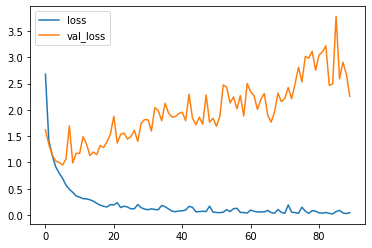

In [29]:
metrics = hist.history
plt.plot(hist.epoch, metrics['loss'],metrics['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

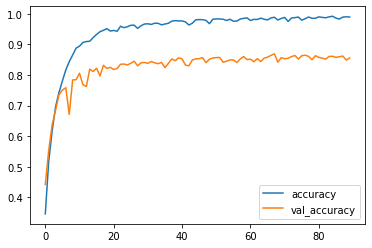

In [30]:
metrics = hist.history
plt.plot(hist.epoch, metrics['accuracy'],metrics['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [33]:
# quick evaludate model
print('Evaluate model with test data')
score = model.evaluate(x=X_test,y=Y_test)

print('test loss:', score[0])
print('test accuracy:', score[1])

Evaluate model with test data
241/241 [==============================] - 3s 13ms/step - loss: 2.2572 - accuracy: 0.8556
test loss: 2.2571816444396973
test accuracy: 0.8555858135223389


In [25]:
#Testing on test data
predictions_1 = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

241/241 [==============================] - 3s 13ms/step - loss: 2.2572 - accuracy: 0.8556
[2.2571816444396973, 0.8555858135223389]


In [26]:
#testing on train data
predictions_2 = model.predict(X_train)
score = model.evaluate(X_train, Y_train)
print(score)

723/723 [==============================] - 10s 13ms/step - loss: 0.0626 - accuracy: 0.9888
[0.06257101893424988, 0.988839864730835]


In [36]:
#Priting confusion matrix to show accuracy 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test.argmax(axis=1), predictions_1.argmax(axis=1))
cm

array([[957,   0,  13,   6,   6,   8,   4,   4,   1,  28],
       [  0, 204,   9,   5,   7,   7,   0,   1,   3,  15],
       [ 18,   3, 731,  75,  17,  30,   2,   6,  27,  96],
       [  8,   1,  75, 563,  15,  18,   3,   2,  41,  37],
       [  3,   2,  10,   7, 750,   6,   4,  26,   5,  13],
       [  7,   0,   7,   6,   6, 978,   0,   8,   2,   9],
       [  0,   0,   0,   7,   2,   2,  95,   0,   7,   1],
       [ 13,   0,   5,   2,  33,  10,   2, 775,   0,  18],
       [ 10,   1,  12,  12,   8,  10,   0,   0, 792,  13],
       [ 25,  12,  69,  36,  31,  23,   5,  15,  17, 749]])